In [1]:
from pysr import PySRRegressor, TemplateExpressionSpec

import matplotlib.pyplot as plt
import numpy as np

import camb

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams['font.family'] = 'stixgeneral'

In [3]:
# Load Data

pars     = np.load('CL_data/parameter_test.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [4]:
past_ells = 1000
n_ells = 4998 - past_ells

# Truncate to ignore first 1000 l's
y_pysr = lensed[:, past_ells:]/unlensed[:, past_ells:]  #lensing

def moving_average(x):
    val = np.convolve(x, np.ones(500), 'valid') / 500
    return val

# Smoothing the Lensing Tail for Training
do_smoothing = True

if do_smoothing:
    y_pysr[:, 249:-250] = np.apply_along_axis(moving_average, axis = 1, arr = y_pysr[:, :])

# Reformatting data
y_pysr = y_pysr.reshape(-1)
# y_pysr : [par1_c502, par1_c503, ..., par1_c5000, par2_c502, ..., par299_c502, ..., par299_c5000]

In [5]:
# Reformatting data
X_ells = np.array([ell for ell in range(past_ells + 2, 5000)])
pars_pysr = pars[:]
X_pysr = np.zeros((y_pysr.shape[0], 3 + 1))  #for the three cosmo parameters plus ells

In [6]:
# Reformatting data
for i in range(100):
    X_pysr[n_ells*i:n_ells*(i+1), :3] = np.tile(pars[i], n_ells).reshape(n_ells, -1)
    X_pysr[n_ells*i:n_ells*(i+1), -1] = X_ells   #final column is ells

# make x3 = ombh2 + omch2 = om0h2
X_pysr[:, 2] = X_pysr[:, 1] + X_pysr[:, 2]  


In [7]:
# Template Function

template = TemplateExpressionSpec(
    expressions = ["g"],
    variable_names = ["x1", "x2", "x3", "x4"],  #H0, ombh2, ombh2+omch2, ells
    parameters = {"beta": 3},  #parameters to vary in the model to create equation - index from 1
    combine = "1 + (beta[1]*(x4/beta[2])^(g(x2, x3)) - 1)*(1 + exp(-(x4-beta[3])/h(x2))^-1"   #find equation of this form
)

# PySR Model

model = PySRRegressor(
    niterations = 100,
    binary_operators = ["+", "-", "*", "pow"],  #allowed operations
    constraints = {'pow': (4, 1), "*": (4, 4)},   #enforces maximum complexities on arguments of operators 
    batching = True, 
    batch_size = 10000, 
    maxsize = 30,
    populations = 20,
    expression_spec = template,
    complexity_of_variables = 2, #global complexity of variables
    procs = 4
)


In [ ]:
# Train

model.fit(X_pysr, y_pysr)

/home/grads/miniconda/envs/megan/lib/python3.9/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 5.180e+00
Progress: 1 / 2000 total iterations (0.050%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
3           9.098e+00  0.000e+00  ╭ g = 0.27038 + 0.27038
                                  ╰ beta = [0.063183, 1.1635, 1.3159]
4           1.203e+00  2.023e+00  ╭ g = 0.27038 + #1
                                  ╰ beta = [0.063183, 1.1635, 1.3159]
5           6.641e-01  5.944e-01  ╭ g = 0.27038 + (0.66731 * 0.25077)
                                  ╰ beta = [0.063183, 1.1635, 1.3159]
8           4.650e-01  1.188e-01  ╭ g = 0.27038 + ((0.66731 - #2) * 0.25077)
                                  ╰ beta = [0.063183, 1.1635, 1.3159]
12          4.178e-01  2.676e-02  ╭ g = 0.1339 + (((#2 + #1) + 0.1339) - #1)
                                  ╰ beta = [0.06318


Expressions evaluated per second: 1.060e+02
Progress: 70 / 2000 total iterations (3.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.598e-01  0.000e+00  ╭ g = 0.99808
                                  ╰ beta = [0.00026732, 0.56332, -0.078443]
23          3.458e-01  1.793e-03  ╭ g = #2 + (((0.44356 * (0.91376 - #2)) + ((#2 * #2) - #1)) + ...
                                  (0.10562 - #1))
                                  ╰ beta = [0.01798, 1.2343, 1.3159]
29          3.128e-01  1.675e-02  ╭ g = (#2 + (((((1.1719 - #2) * 0.63383) + (#2 * #2)) - #1) + ...
                                  ((-0.024585 - #1) + #2))) - #2
                                  ╰ beta = [0.0046068, 1.3166, 1.3159]
──────────────────────────────────────────────────────────────────────────────────────


Expressions evaluated per second: 1.170e+02
Progress: 146 / 2000 total iterations (7.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.587e-01  0.000e+00  ╭ g = 1.0994
                                  ╰ beta = [0.00061665, 2.6969, 1.9012]
4           3.207e-01  3.740e-02  ╭ g = #2 + 1.048
                                  ╰ beta = [0.00028984, 2.3186, 2.05]
9           2.444e-01  5.431e-02  ╭ g = ((#1 * -8.3302) + #2) + 1.0505
                                  ╰ beta = [0.0023558, 5.432, 2.4956]
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per sec


Expressions evaluated per second: 1.250e+02
Progress: 252 / 2000 total iterations (12.600%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.587e-01  0.000e+00  ╭ g = 1.0841
                                  ╰ beta = [0.00058412, 2.3176, 2.05]
4           3.206e-01  3.739e-02  ╭ g = #2 + 0.94537
                                  ╰ beta = [0.00061817, 2.3368, 2.05]
6           2.906e-01  4.915e-02  ╭ g = (#1 * -6.8852) + 1.2672
                                  ╰ beta = [0.00058162, 3.0556, 2.2776]
9           2.372e-01  6.765e-02  ╭ g = ((#1 * -7.822) + #2) + 1.3449
                                  ╰ beta = [0.00012426, 2.6237, 3.3068]
───────────────────────────────────────────────────────────────────────────────────────────────────
═════════════════════════════════════════════


Expressions evaluated per second: 1.040e+02
Progress: 296 / 2000 total iterations (14.800%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.587e-01  0.000e+00  ╭ g = 1.0841
                                  ╰ beta = [0.00058412, 2.3176, 2.05]
4           3.206e-01  3.739e-02  ╭ g = #2 + 0.94537
                                  ╰ beta = [0.00061817, 2.3368, 2.05]
6           2.906e-01  4.915e-02  ╭ g = (#1 * -6.8852) + 1.2672
                                  ╰ beta = [0.00058162, 3.0556, 2.2776]
9           2.372e-01  6.765e-02  ╭ g = ((#1 * -7.822) + #2) + 1.3449
                                  ╰ beta = [0.00012426, 2.6237, 3.3068]
12          2.372e-01  1.261e-04  ╭ g = 1.3449 + ((#1 * (-7.822 - #1)) + #2)
                                  ╰ beta = [0.00012426, 2.6237, 3.30


Expressions evaluated per second: 6.530e+01
Progress: 326 / 2000 total iterations (16.300%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.587e-01  0.000e+00  ╭ g = 1.0841
                                  ╰ beta = [0.00058412, 2.3176, 2.05]
4           3.206e-01  3.739e-02  ╭ g = #2 + 0.94537
                                  ╰ beta = [0.00061817, 2.3368, 2.05]
6           2.906e-01  4.915e-02  ╭ g = (#1 * -6.8852) + 1.2672
                                  ╰ beta = [0.00058162, 3.0556, 2.2776]
9           2.372e-01  6.778e-02  ╭ g = (#1 * -7.822) + (#2 + 1.3137)
                                  ╰ beta = [0.00015285, 2.6231, 3.3068]
11          2.368e-01  8.092e-04  ╭ g = (#1 * -7.812) + ((#2 - -0.068956) + 1.1955)
                                  ╰ beta = [0.00021497, 2.582


Expressions evaluated per second: 5.240e+01
Progress: 352 / 2000 total iterations (17.600%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.587e-01  0.000e+00  ╭ g = 1.0841
                                  ╰ beta = [0.00058412, 2.3176, 2.05]
4           3.206e-01  3.739e-02  ╭ g = #2 + 0.94537
                                  ╰ beta = [0.00061817, 2.3368, 2.05]
6           2.906e-01  4.915e-02  ╭ g = (#1 * -6.8852) + 1.2672
                                  ╰ beta = [0.00058162, 3.0556, 2.2776]
9           2.372e-01  6.778e-02  ╭ g = (#1 * -7.822) + (#2 + 1.3137)
                                  ╰ beta = [0.00015285, 2.6231, 3.3068]
11          2.368e-01  8.092e-04  ╭ g = (#1 * -7.812) + ((#2 - -0.068956) + 1.1955)
                                  ╰ beta = [0.00021497, 2.582


Expressions evaluated per second: 5.530e+01
Progress: 372 / 2000 total iterations (18.600%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.587e-01  0.000e+00  ╭ g = 1.0841
                                  ╰ beta = [0.00058412, 2.3176, 2.05]
4           3.206e-01  3.739e-02  ╭ g = #2 + 0.94537
                                  ╰ beta = [0.00061817, 2.3368, 2.05]
6           2.906e-01  4.915e-02  ╭ g = (#1 * -6.8852) + 1.2672
                                  ╰ beta = [0.00058162, 3.0556, 2.2776]
9           2.372e-01  6.778e-02  ╭ g = (#1 * -7.822) + (#2 + 1.3137)
                                  ╰ beta = [0.00015285, 2.6231, 3.3068]
11          2.368e-01  8.092e-04  ╭ g = (#1 * -7.812) + ((#2 - -0.068956) + 1.1955)
                                  ╰ beta = [0.00021497, 2.582

In [9]:
ells = np.array([l for l in range(2, 5000)])

In [32]:
print(model.equations_["equation"][4])

g = ((#1 * -7.441622) + #2) + 1.2563524; beta = [9.798213e-5, 1.3559264, 1.3656833]


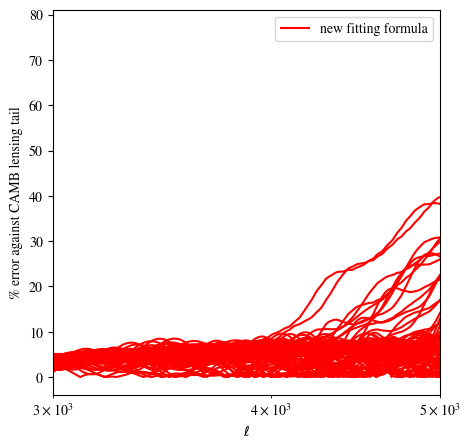

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

# Final Fit

def lensing_tail_fit(ell, ombh2, omch2):
    beta_1 = 1.0334532   # 0.83
    beta_2 = 2740.4236    # 1400/0.4531
    beta_3 = -0.48106384   # 1.62
    beta_4 = 2000   #2000

    # Sigmoid
    sigm = (1 + np.exp(-(ell-beta_3*beta_4)/100))**(-1)

    # Exponent
    #alpha = (ombh2**-0.877) * (ombh2 + omch2) - 3.342*(ombh2 + omch2) - 1.118
    alpha = ombh2 + omch2

    # Polynomial
    poly = (beta_1*(ell/beta_2)**alpha - 1)

    L = poly*sigm + 1


    return L


# Fit % Error for 100 Cosmologies
for ind in range(0, 100):
    ax.semilogx(ells, 100*np.abs(lensing_tail_fit(ells, pars_pysr[ind, 1], pars_pysr[ind, 2]) - lensed[ind]/unlensed[ind])/(lensed[ind]/unlensed[ind]), "r", label='new fitting formula')


ax.set_xlim(3000, 5000)
ax.set_xlabel("$\\ell$")

ax.set_ylabel("% error against CAMB lensing tail")


handles, labels = fig.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)


In [12]:
#analysis of the fit

In [13]:
error = [100*np.abs(lensing_tail_fit(ells, pars_pysr[ind, 1], pars_pysr[ind, 2]) - lensed[ind]/unlensed[ind])/(lensed[ind]/unlensed[ind]) for ind in range(0, 100)]

#pars10 = [pars_pysr[i] if np.max(error[i]) > 10 else pass for i in range(0,100)]
#pars10[10][1]
i20 = []
for i in range(len(error)):
    if np.max(error[i])> 20:
        i20.append(i)
i10 = []
for i in range(len(error)):
    if np.max(error[i])> 10:
        i10.append(i)

In [67]:
# PLOTS BELOW vvvvv

In [68]:
pars = camb.set_params(H0 = 67.4, ombh2 = 0.0224, omch2 = 0.12, lmax=5000)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
fiducial_lensed = powers['total'][2:5000, 0]
fiducial_unlensed = powers['unlensed_total'][2:5000, 0]
ells = np.array([l for l in range(2, 5000)])

from cycler import cycler
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))


<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/80105674.py:38: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$", fontsize = 16)


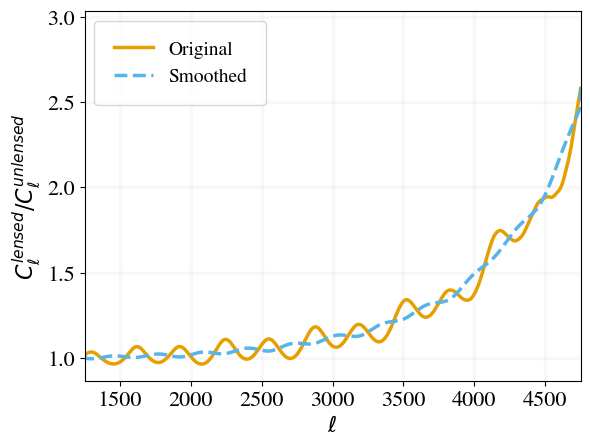

In [69]:
fig, ax = plt.subplots(1, 1)

fiducial_lensing = fiducial_lensed/fiducial_unlensed

#ax.loglog(ells, fiducial_lensing)

past_ells = 1000
n_ells = 4998 - past_ells

def moving_average(x):
    val = np.convolve(x, np.ones(500), 'valid') / 500
    return val

fiducial_smoothed = np.apply_along_axis(moving_average, axis = 0, arr = fiducial_lensing[1000:])

fiducial_smoothed = np.concatenate((fiducial_lensing[:1250], fiducial_smoothed))
fiducial_smoothed = np.concatenate((fiducial_smoothed, fiducial_lensing[-249:]))

#ax.loglog(ells, fiducial_smoothed)


plt.rc("axes", prop_cycle=line_cycler)


plt.plot(ells, fiducial_lensing, label = f"Original", lw=2.5)
plt.plot(ells, fiducial_smoothed, label = f"Smoothed", lw=2.5)


#plt.loglog([0.007, 0.007],[7e-5, 1], label = "$k_{eq}$")
#plt.semilogx(a.khs*a.h, a.GA_transfer, label = f"GA")
#plt.semilogx(a.khs*a.h, a.BBKS_transfer, label = f"BBKS")
#plt.semilogx(a.khs*a.h, a.EH_transfer, label = f"EH")
plt.grid(alpha=0.15, color='lightgray', lw=2.5)

plt.xlim(1250, 4750)

plt.ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 16)
plt.xlabel("$\ell$", fontsize = 16)
plt.legend(loc="upper left", fontsize = 14, borderpad = 1)

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.savefig("fiducial_smoothing.pdf", format="pdf", bbox_inches='tight')

In [70]:
ombh2vals = np.array([0.012, 0.02])
omch2vals = np.array([0.1, 0.13])

par_arr = []
lensing_tails = []

for _ombh2 in ombh2vals:
    for _omch2 in omch2vals:

        par_arr.append((_ombh2, _omch2))
        
        pars = camb.set_params(H0 = 67.4, ombh2 = _ombh2, omch2 = _omch2, lmax=5000)
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        lensing_tails.append(powers['total'][2:5000, 0]/ powers['unlensed_total'][2:5000, 0])


<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/4170293192.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$", fontsize = 16)


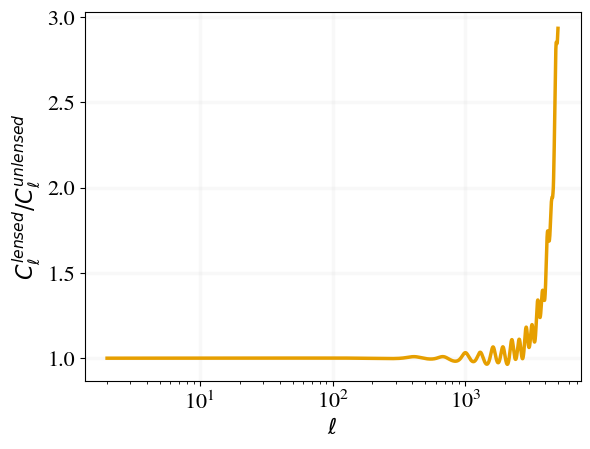

In [71]:
plt.rc("axes", prop_cycle=line_cycler)


plt.semilogx(ells, fiducial_lensing, label = f"CAMB", lw=2.5)

#plt.loglog([0.007, 0.007],[7e-5, 1], label = "$k_{eq}$")
#plt.semilogx(a.khs*a.h, a.GA_transfer, label = f"GA")
#plt.semilogx(a.khs*a.h, a.BBKS_transfer, label = f"BBKS")
#plt.semilogx(a.khs*a.h, a.EH_transfer, label = f"EH")
plt.grid(alpha=0.15, color='lightgray', lw=2.5)

plt.ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 16)
plt.xlabel("$\ell$", fontsize = 16)
#plt.legend()

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.savefig("fiducial_lensing_tail.pdf", format="pdf", bbox_inches='tight')

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/1044998282.py:19: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
/tmp/ipykernel_15643/1044998282.py:20: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel("$\ell$", fontsize = 16)
/tmp/ipykernel_15643/1044998282.py:32: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel("$\ell$", fontsize = 16)


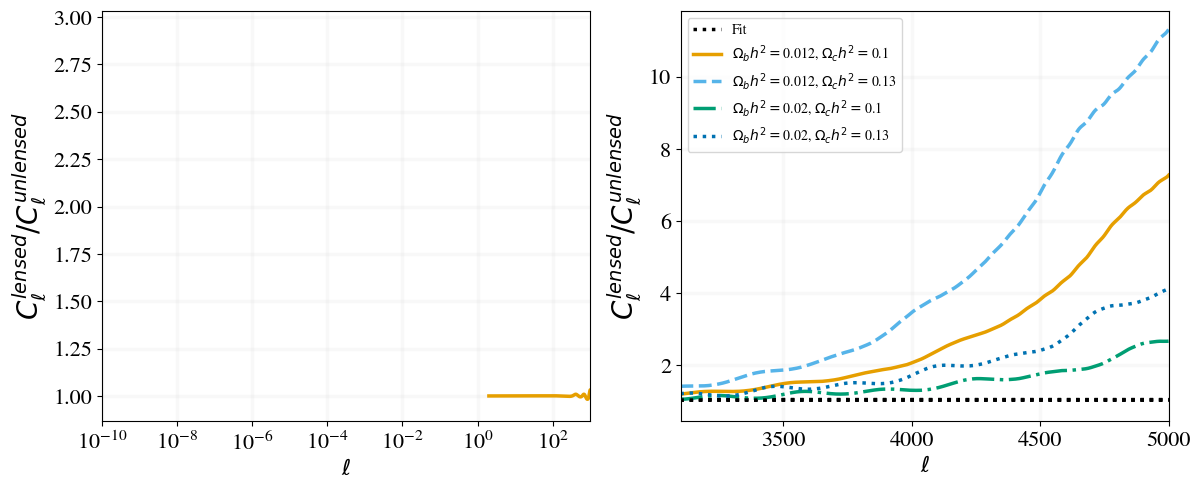

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    if i == 0:
        ax[1].plot(ells, lensing_tail_fit(ells, par_arr[i][0], par_arr[i][1]), linestyle = ":", color = "k",label = rf"Fit", lw=2.5)
    else:
        ax[1].plot(ells, lensing_tail_fit(ells, par_arr[i][0], par_arr[i][1]), linestyle = ":", color = "k", lw=2.5)#, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)
    
    ax[1].plot(ells, lensings, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)



ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_xlim(1e-10, 1000)
ax[1].set_xlim(3100, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
#plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')

<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/106933412.py:12: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
/tmp/ipykernel_15643/106933412.py:13: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel("$\ell$", fontsize = 16)
/tmp/ipykernel_15643/106933412.py:24: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel("$\ell$", fontsize = 16)


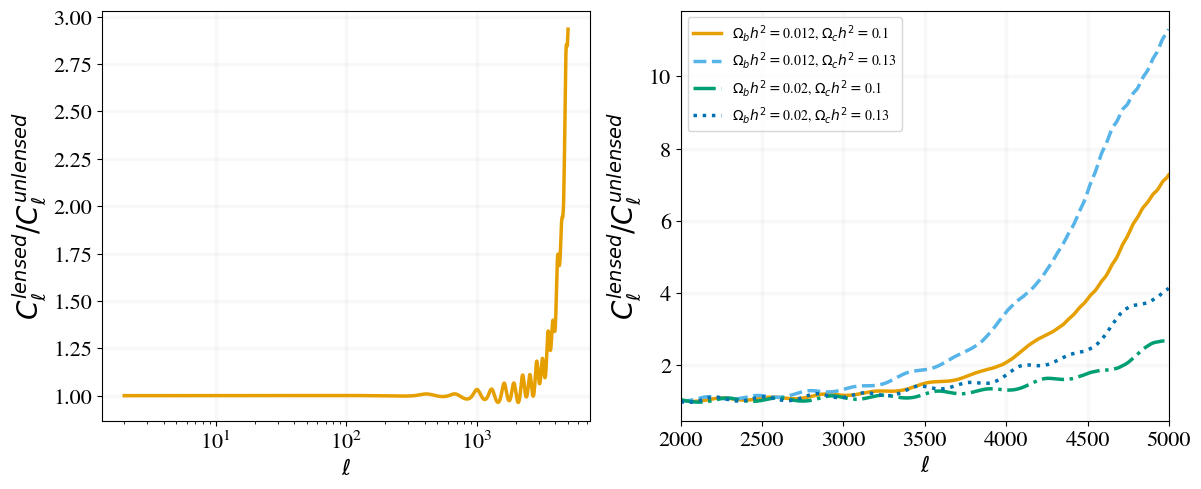

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    ax[1].plot(ells, lensings, label = rf"$\Omega_bh^2=${round(par_arr[i][0], 4)}, $\Omega_ch^2=${round(par_arr[i][1], 3)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[1].set_xlim(2000, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')

<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15643/2238070813.py:21: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel("$L(\ell)$", fontsize = 16)
/tmp/ipykernel_15643/2238070813.py:22: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel("$\ell$", fontsize = 16)
/tmp/ipykernel_15643/2238070813.py:34: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel("$\ell$", fontsize = 16)


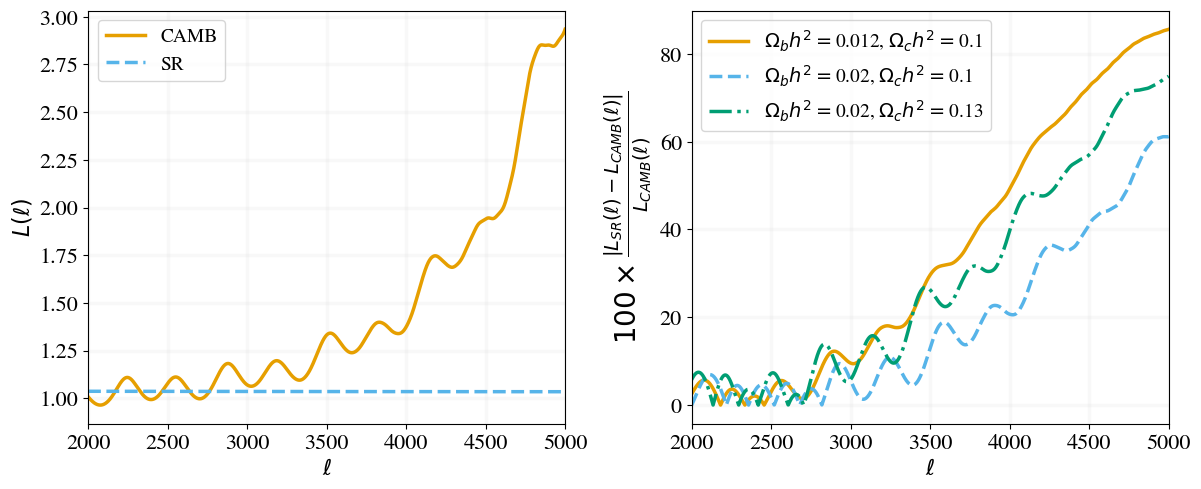

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)


ax[0].plot(ells, fiducial_lensing, lw=2.5, label = "CAMB")
ax[0].plot(ells, lensing_tail_fit(ells, 0.0224, 0.12), lw=2.5, label = "SR")


for i, lensings in enumerate(lensing_tails):
    if i == 0 or i == 2 or i == 3:
        omb = par_arr[i][0]
        omc = par_arr[i][1]
    
        fit = lensing_tail_fit(ells, omb, omc)
        
        ax[1].plot(ells, 100*np.abs(fit-lensings)/lensings, label = rf"$\Omega_bh^2=${round(omb, 4)}, $\Omega_ch^2=${round(omc, 3)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$L(\ell)$", fontsize = 16)
ax[0].set_xlabel("$\ell$", fontsize = 16)

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[0].set_xlim(2000, 5000)
ax[1].set_xlim(2000, 5000)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)


ax[1].set_ylabel(r"$100\times\frac{|L_{SR}(\ell) - L_{CAMB}(\ell)|}{L_{CAMB}(\ell)}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[0].legend(fontsize = 14)

ax[1].legend(fontsize = 14)

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
plt.savefig("lensing_tail_errors.pdf", format="pdf", bbox_inches='tight')

In [55]:


def average_error(omb, omc):
    ells_2000 = np.array([ell for ell in range(3200, 5000)])

    n_ells = len(ells_2000)
    
    pars = camb.set_params(H0 = 67.4, ombh2 = omb, omch2 = omc, lmax=5000)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    camb_lensing = powers['total'][3200:5000, 0]/ powers['unlensed_total'][3200:5000, 0]

    fit = lensing_tail_fit(ells_2000, omb, omc)

    errs = 100*np.abs(fit-camb_lensing)/camb_lensing

    return errs.sum()/n_ells



In [22]:
ombh2vals = np.array([0.012, 0.02])
omch2vals = np.array([0.1, 0.13])

for omb in ombh2vals:
    for omc in omch2vals:
        print(f"omb = {omb}, omc = {omc}, avg_error: {average_error(omb, omc)}")


omb = 0.012, omc = 0.1, avg_error: 14.869632560167288
omb = 0.012, omc = 0.13, avg_error: 7.954793567299639
omb = 0.02, omc = 0.1, avg_error: 20.80238904598929
omb = 0.02, omc = 0.13, avg_error: 15.241884766404421


In [21]:
ombh2_vals_meshgrid = np.linspace(0.006, 0.04, 10)
omch2_vals_meshgrid = np.linspace(0.05, 0.3, 10)

lensing_avg_error = np.zeros((10, 10))

for i, omb in enumerate(ombh2_vals_meshgrid):
    for j, omc in enumerate(omch2_vals_meshgrid):
        
        print(f"currently: {10*i + j + 1}/100")
        
        lensing_avg_error[i, j] = average_error(omb, omc)

currently: 1/100
currently: 2/100
currently: 3/100
currently: 4/100
currently: 5/100
currently: 6/100
currently: 7/100
currently: 8/100
currently: 9/100
currently: 10/100
currently: 11/100
currently: 12/100
currently: 13/100
currently: 14/100
currently: 15/100
currently: 16/100
currently: 17/100
currently: 18/100
currently: 19/100
currently: 20/100
currently: 21/100
currently: 22/100
currently: 23/100
currently: 24/100
currently: 25/100
currently: 26/100
currently: 27/100
currently: 28/100
currently: 29/100
currently: 30/100
currently: 31/100
currently: 32/100
currently: 33/100
currently: 34/100
currently: 35/100
currently: 36/100
currently: 37/100
currently: 38/100
currently: 39/100
currently: 40/100
currently: 41/100
currently: 42/100
currently: 43/100
currently: 44/100
currently: 45/100
currently: 46/100
currently: 47/100
currently: 48/100
currently: 49/100
currently: 50/100
currently: 51/100
currently: 52/100
currently: 53/100
currently: 54/100
currently: 55/100
currently: 56/100
c

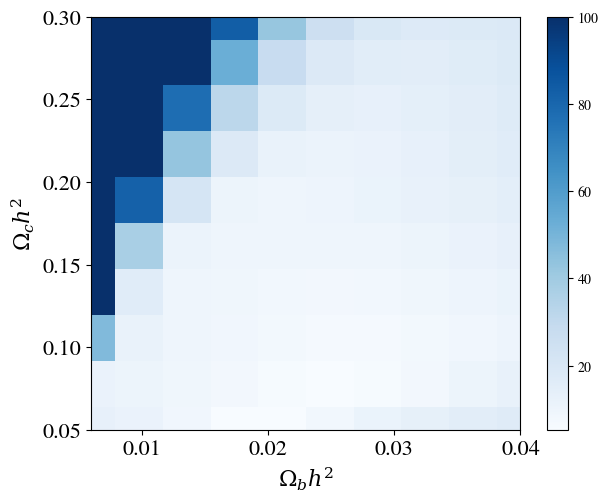

In [22]:
x, y = np.meshgrid(omch2_vals_meshgrid, ombh2_vals_meshgrid)

fig, ax = plt.subplots(1, 1)

z1 = lensing_avg_error

c = ax.pcolormesh(y, x, z1, cmap='Blues', vmax = 100)
ax.axis([y.min(), y.max(), x.min(), x.max() ])

#ax.set_title('EH', fontsize = 16, fontname="Helvetica")

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

fig.tight_layout()

fig.colorbar(c, ax=ax)

ax.set_ylabel(r"$\Omega_c h^2$", fontsize = 16)
ax.set_xlabel(r"$\Omega_b h^2$", fontsize = 16)

plt.savefig("lensing_tail_errors_grid.pdf", format="pdf", bbox_inches='tight')

In [23]:
pars     = np.load('CL_data/parameter_test2.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL2.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL2.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [24]:
lensing_tails = lensed/unlensed

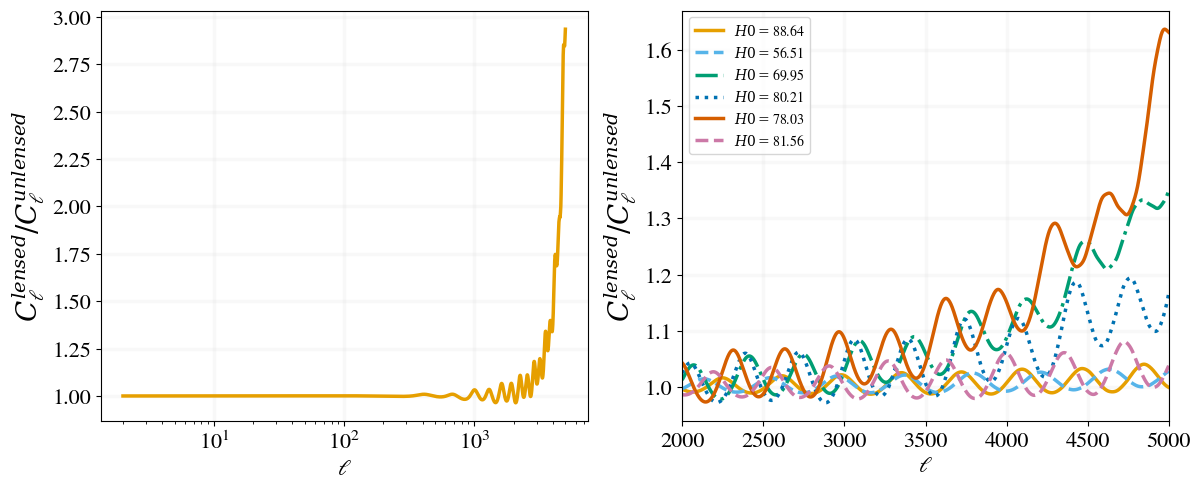

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)

plt.rc("axes", prop_cycle=line_cycler)

ax[0].semilogx(ells, fiducial_lensing, lw=2.5)

for i, lensings in enumerate(lensing_tails):
    if i <=5 :
        ax[1].plot(ells, lensings, label = rf"$H0=${round(pars[i, 0], 2)}", lw=2.5)

ax[0].grid(alpha=0.15, color='lightgray', lw=2.5)

ax[0].set_ylabel("$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize = 20)
ax[0].set_xlabel("$\ell$", fontsize = 16)
#plt.legend()

ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

ax[1].grid(alpha=0.15, color='lightgray', lw=2.5)

#ax[0].set_xlim(1e-10, 1000)
ax[1].set_xlim(2000, 5000)

ax[1].set_ylabel(r"$C_{\ell}^{lensed}/C_{\ell}^{unlensed}$", fontsize=20)
ax[1].set_xlabel("$\ell$", fontsize = 16)
ax[1].legend(loc = "upper left")

ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

fig.tight_layout()
#plt.savefig("sample_lensing_tails.pdf", format="pdf", bbox_inches='tight')